Import cleaned csv with all features included

In [203]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    log_loss, roc_auc_score, brier_score_loss, accuracy_score, f1_score
)
import matplotlib.pyplot as plt

path = "../intermediate/schedules_cleaned.csv"

df_raw = pd.read_csv(path)

Delete any columns that would leak data from present or future games

In [204]:
leakage_cols = [
    # direct outcomes
    "home_score", "away_score", "team_score", "opp_score", 
    "point_diff", "Winner",

    # current team stats (not prior)
    "team_fga", "team_fgm", "team_first_down", "team_fumbles_lost",
    "team_pass_att", "team_pass_cmp", "team_pass_int",
    "team_pass_sacked", "team_pass_td", "team_pass_yds",
    "team_penalties", "team_penalties_yds",
    "team_plays_offense",
    "team_rush_att", "team_rush_td", "team_rush_yds",
    "team_turnovers",
    "team_xpa", "team_xpm",
    "team_punt", "team_punt_yds",
    "team_pass_sacked_yds",

    # current opponent stats (not prior)
    "opp_fga", "opp_fgm", "opp_first_down", "opp_fumbles_lost",
    "opp_pass_att", "opp_pass_cmp", "opp_pass_int",
    "opp_pass_sacked", "opp_pass_td", "opp_pass_yds",
    "opp_penalties", "opp_penalties_yds",
    "opp_plays_offense",
    "opp_rush_att", "opp_rush_td", "opp_rush_yds",
    "opp_turnovers",
    "opp_xpa", "opp_xpm",
    "opp_punt", "opp_punt_yds",
    "opp_pass_sacked_yds"
]

df_work = df_raw.drop(columns=[c for c in leakage_cols if c in df_raw.columns], errors="ignore")

# --- Leak kill-switch: drop all current-week injury/severity columns ---
# Keep ONLY *_prior1. Everything else derived from injuries must go.
prefixes = ("inj_", "sev_", "prac_sev_")

# Columns that are grouped CURRENT-WEEK aggregates (don’t have the inj_/sev_/prac_ prefix)
grouped_current_week = {
    "inj_qb_flag","inj_skill","inj_ol","inj_dl","inj_secondary","inj_front7","inj_total",
    "sev_qb","sev_skill_mean","sev_ol_mean","sev_dl_mean","sev_secondary_mean","sev_total_mean",
    "prac_sev_total_mean",
}

prefixes = ("inj_", "sev_", "prac_sev_")

leak_cols = [
    c for c in df_work.columns
    if c.startswith(prefixes) and not c.endswith("_prior1")
]

# drop them
df_work.drop(columns=leak_cols, inplace=True, errors="ignore")

print(f"Dropped {len(leak_cols)} potential-leak columns.")
if leak_cols:
    print("Examples:", leak_cols[:15])

# sanity check: no non-prior injury/severity columns remain
leftovers = [c for c in df_work.columns if c.startswith(prefixes) and not c.endswith("_prior1")]
assert len(leftovers) == 0, f"Leakage risk: found non-prior injury cols still present: {leftovers[:10]}"


Dropped 65 potential-leak columns.
Examples: ['inj_', 'inj_C', 'inj_CB', 'inj_DE', 'inj_DT', 'inj_FB', 'inj_G', 'inj_K', 'inj_LB', 'inj_LS', 'inj_P', 'inj_QB', 'inj_RB', 'inj_S', 'inj_T']


Drop any target rows that are missing a value

In [205]:
# --- 3) Drop rows missing essential fields
print("Missing team_moneyline:", df_work["team_moneyline"].isna().sum())
df_work = df_work.dropna(subset=["team_moneyline"])  # keep if you really want to require this
df_work = df_work.dropna(subset=["team_win"])        # ensure target present

# Ensure binary target
df_work["team_win"] = df_work["team_win"].astype(int)

Missing team_moneyline: 2


In [206]:
# --- 3) Feature selection (numeric only; exclude IDs, text, market, and target)
drop_exact = {
    "team_win","team_prob_novig", "opp_prob_novig", "spread_line", "total_line",
    "team_moneyline","opp_moneyline",      # markets / target-adjacent
    "game_id","team","opponent","home_team","away_team",
    "referee","team_coach","opp_coach","stadium","location",
    "weekday","gametime","game_type","date","Winner",
    # keep season/week in the dataframe for splitting, but don't model them:
    "season","week"
}

num_cols = []
dropped_non_numeric = []

for c in df_work.columns:
    if c in drop_exact:
        continue
    if pd.api.types.is_numeric_dtype(df_work[c]):
        num_cols.append(c)
    else:
        dropped_non_numeric.append(c)

print("Dropped for non-numeric:", dropped_non_numeric)
print(f"Initial numeric feature count: {len(num_cols)}")

# Define X/y now from the working frame, but keep df_work intact for splitting
X_full_all = df_work[num_cols].copy()
y_full_all = df_work["team_win"].values

Dropped for non-numeric: []
Initial numeric feature count: 409


Time split to ensure only pruning learned on training data

In [ ]:
# --- 5) Time-based split: last season as test (uses df_work, which still has 'season')
last_season = int(df_work["season"].max())
train_idx = df_work["season"] < last_season
test_idx  = df_work["season"] == last_season

train = df_work.loc[train_idx].copy()
cal   = df_work[df_work["season"] == last_season-1].copy()
test  = df_work.loc[test_idx].copy()

print(f"Train seasons: {sorted(train['season'].unique())}")
print("Cal season   :", sorted(cal["season"].unique()))
print(f"Test season  : {sorted(test['season'].unique())}")
print(f"Train/Test sizes: {len(train)}/{len(test)}")

X_train, y_train = train[num_cols], train["team_win"].values
X_cal,   y_cal   = cal[num_cols],   cal["team_win"].values
X_test,  y_test  = test[num_cols],  test["team_win"].values

Train seasons: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Cal season   : [2022]
Test seasons : [2023, 2024]
Train/Cal/Test sizes: 4878/568/1140


Drop According to Pre Checks

In [208]:
# --- Pre-screen columns BEFORE pruning
def prescreen_columns(df, miss_thresh=0.80, freq_cut=95/5, unique_cut=0.10):
    drop_reasons = {}

    # extreme missingness
    miss_cols = df.columns[df.isna().mean() > miss_thresh]
    for c in miss_cols:
        drop_reasons[c] = f"Missingness > {miss_thresh:.0%} ({df[c].isna().mean():.1%})"

    # constants & near-zero variance
    for c in df.columns:
        if c in drop_reasons:  # already flagged
            continue
        s = df[c]

        # constant
        if s.nunique(dropna=True) <= 1:
            drop_reasons[c] = "Constant (≤1 unique value)"
            continue

        # NZV (Kuhn’s heuristic)
        vc = s.value_counts(dropna=True)
        if len(vc) == 1:
            drop_reasons[c] = "Single value (all same)"
            continue

        freq_ratio = vc.iloc[0] / (vc.iloc[1] if len(vc) > 1 else 1)
        unique_pct = s.nunique(dropna=True) / len(s)

        if (freq_ratio > freq_cut) and (unique_pct < unique_cut):
            drop_reasons[c] = (f"Near-zero variance: freq_ratio={freq_ratio:.1f}, "
                               f"unique_pct={unique_pct:.1%}")

    df = df.drop(columns=list(drop_reasons.keys()), errors="ignore")
    return df, drop_reasons


# --- Apply prescreen to TRAIN ONLY (then align CAL/TEST to same kept columns)

cols_before = list(X_train.columns)
print("Before prescreen:", len(cols_before), "numeric candidates")

X_train_all, pre_drop = prescreen_columns(X_train, miss_thresh=0.80)

print("Pre-screen dropped:", len(pre_drop))
for col, reason in pre_drop.items():
    print(f"{col}: {reason}")

# What actually changed (sanity check)
cols_after = list(X_train_all.columns)
dropped_actual = [c for c in cols_before if c not in cols_after]
silent = [c for c in dropped_actual if c not in pre_drop]  # would indicate a drop elsewhere
if silent:
    print("Dropped without prescreen reason (likely earlier step):", len(silent))
    print(silent[:25])

# Update feature list & align all splits
num_cols  = cols_after
X_train_all = X_train[num_cols].copy()
X_cal_all   = X_cal[num_cols].copy()     # <- align CAL too
X_test_all  = X_test[num_cols].copy()

print("After prescreen:", len(num_cols), "numeric candidates")

Before prescreen: 409 numeric candidates
Pre-screen dropped: 28
inj__prior1: Constant (≤1 unique value)
inj_FB_prior1: Near-zero variance: freq_ratio=74.0, unique_pct=0.1%
inj_LS_prior1: Near-zero variance: freq_ratio=33.4, unique_pct=0.0%
inj_P_prior1: Near-zero variance: freq_ratio=27.7, unique_pct=0.0%
sev__prior1: Constant (≤1 unique value)
sev_FB_prior1: Near-zero variance: freq_ratio=230.7, unique_pct=0.1%
sev_K_prior1: Near-zero variance: freq_ratio=54.8, unique_pct=0.1%
sev_LS_prior1: Near-zero variance: freq_ratio=141.7, unique_pct=0.1%
sev_P_prior1: Near-zero variance: freq_ratio=133.0, unique_pct=0.1%
prac_sev__prior1: Constant (≤1 unique value)
prac_sev_FB_prior1: Near-zero variance: freq_ratio=230.6, unique_pct=0.1%
prac_sev_K_prior1: Near-zero variance: freq_ratio=57.6, unique_pct=0.1%
prac_sev_LS_prior1: Near-zero variance: freq_ratio=155.6, unique_pct=0.1%
prac_sev_P_prior1: Near-zero variance: freq_ratio=95.9, unique_pct=0.1%
league_avg_pd: Constant (≤1 unique value)
l

In [209]:
def reduce_correlated(X, threshold=0.90, prefer="higher_var"):
    """
    Collapse highly-correlated groups (absolute corr >= threshold) to a single column.
    prefer: "higher_var" or "first"
    Returns: kept_cols, dropped_cols, cluster_map (cluster_id -> [cols])
    """
    corr = X.corr(numeric_only=True).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    # Build clusters
    visited = set()
    clusters = []
    cols = list(X.columns)
    for i, c in enumerate(cols):
        if c in visited:
            continue
        group = {c}
        partners = set(upper.columns[(upper.loc[c] >= threshold) | (upper[c] >= threshold)].tolist())
        frontier = set(partners)
        while frontier:
            n = frontier.pop()
            if n in group:
                continue
            group.add(n)
            visited.add(n)
            new_partners = set(upper.columns[(upper.loc[n] >= threshold) | (upper[n] >= threshold)].tolist())
            frontier |= (new_partners - group)
        visited |= group
        if len(group) > 1:
            clusters.append(sorted(list(group)))
    # Decide winners
    kept, dropped, cmap = [], [], {}
    for k, grp in enumerate(clusters, start=1):
        if prefer == "higher_var":
            winner = X[grp].var().sort_values(ascending=False).index[0]
        else:
            winner = grp[0]
        losers = [g for g in grp if g != winner]
        kept.append(winner)
        dropped.extend(losers)
        cmap[f"cluster_{k}"] = grp
    # Add columns not in any cluster
    in_any = set(sum(clusters, []))
    kept = kept + [c for c in X.columns if c not in in_any]
    return kept, dropped, cmap

# --- Usage: correlation reduction ---
kept_corr, dropped_corr, cluster_map = reduce_correlated(
    X_train_all, threshold=0.90, prefer="higher_var"
)

# --- Run correlation prune on current working sets ---
kept_corr, dropped_corr, cluster_map = reduce_correlated(
    X_train_all, threshold=0.90, prefer="higher_var"
)

print("Correlation prune dropped:", len(dropped_corr))
for cid, cols in cluster_map.items():
    dropped_here = [c for c in cols if c in dropped_corr]
    if dropped_here:
        print(f"{cid}: dropped {dropped_here}")

# --- Update feature list & align all splits (in-place style) ---
num_cols = kept_corr
X_train_all = X_train_all[num_cols].copy()
X_cal_all   = X_cal_all[num_cols].copy()
X_test_all  = X_test_all[num_cols].copy()

print("After correlation prune:", len(num_cols), "numeric candidates")

Correlation prune dropped: 120
cluster_1: dropped ['inj_qb_flag_prior1']
cluster_2: dropped ['sev_qb_prior1']
cluster_3: dropped ['team_fgm_prior1']
cluster_4: dropped ['team_xpm_prior1']
cluster_5: dropped ['opp_fgm_prior1']
cluster_6: dropped ['opp_xpm_prior1']
cluster_7: dropped ['team_pass_yds_ewm', 'team_pass_yds_roll5']
cluster_8: dropped ['team_rush_yds_ewm', 'team_rush_yds_roll5']
cluster_9: dropped ['team_pass_td_ewm', 'team_pass_td_rate_roll3', 'team_pass_td_rate_roll5', 'team_pass_td_roll5']
cluster_10: dropped ['team_rush_td_ewm', 'team_rush_td_roll5']
cluster_11: dropped ['team_turnovers_ewm']
cluster_12: dropped ['team_score_ewm', 'team_score_roll5']
cluster_13: dropped ['team_pass_att_ewm', 'team_pass_att_roll5']
cluster_14: dropped ['team_pass_rate_roll3', 'team_pass_rate_roll5', 'team_rush_att_ewm', 'team_rush_att_roll5', 'team_rush_rate_roll3', 'team_rush_rate_roll5']
cluster_15: dropped ['team_first_down_ewm', 'team_first_down_roll5']
cluster_16: dropped ['team_penal

In [210]:
import re
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss

def prune_rolling_families_with_val(
    X_tr: pd.DataFrame,
    y_tr: pd.Series | np.ndarray,
    X_val: pd.DataFrame,
    y_val: pd.Series | np.ndarray,
    keep_per_family: int = 2,
    window_tokens: tuple = ("ra", "roll", "avg", "ewm", "win"),
    n_repeats: int = 5,
    random_state: int = 42,
):
    """
    Keep only the best N windows per rolling family (e.g., _ra3/_ra5/_ra10),
    chosen by permutation importance (OOS logloss decrease) on a provided
    validation split (your CAL season).

    Returns:
      kept_cols, dropped_cols, family_map, perm_scores (Series on X_val cols)
    """
    # Ensure column alignment
    common = [c for c in X_tr.columns if c in X_val.columns]
    X_tr = X_tr[common].copy()
    X_val = X_val[common].copy()

    # 1) discover families: <root> _ <token> <digits>  e.g., team_pass_yds_ra10
    token_alt = "|".join(map(re.escape, window_tokens))
    pat = re.compile(rf"^(.*?)(?:_({token_alt}))(\d+)$")

    families: dict[str, list[str]] = {}
    for c in X_tr.columns:
        m = pat.match(c)
        if m:
            root, tok, _n = m.groups()
            fam_key = f"{root}_{tok}"
            families.setdefault(fam_key, []).append(c)
    families = {k: v for k, v in families.items() if len(v) >= 2}
    if not families:
        return list(X_tr.columns), [], {}, pd.Series(dtype=float)

    # 2) fit quick model on TRAIN, evaluate on CAL
    model = XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=2.0, objective="binary:logistic",
        eval_metric="logloss", tree_method="hist",
        random_state=random_state
    )
    model.fit(X_tr, y_tr, verbose=False)

    base_ll = log_loss(y_val, model.predict_proba(X_val)[:, 1])

    pi = permutation_importance(
        model, X_val, y_val,
        scoring="neg_log_loss", n_repeats=n_repeats, random_state=random_state
    )
    perm_scores = pd.Series(pi.importances_mean, index=X_val.columns).reindex(X_tr.columns).fillna(0.0)
    perm_scores = -1.0 * perm_scores  # convert to "logloss decrease" (higher = more important)

    # 3) keep top-k per family
    keep = set(X_tr.columns)
    dropped = []
    for fam_key, cols in families.items():
        sub = perm_scores.loc[[c for c in cols if c in perm_scores.index]].sort_values(ascending=False)
        keep_cols = list(sub.index[:keep_per_family])
        to_drop = [c for c in cols if c not in keep_cols]
        for c in to_drop:
            if c in keep:
                keep.remove(c); dropped.append(c)

    kept_cols = sorted(list(keep))
    print(f"[Family prune] Dropped {len(dropped)} window features across {len(families)} families "
          f"(cal logloss baseline={base_ll:.4f}).")
    return kept_cols, dropped, families, perm_scores

# --- Rolling-family prune (use CAL season as validation)
# Make sure y_train / y_cal are Series aligned to X_train_all / X_cal (not arrays)
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train, index=train.index)
if not isinstance(y_cal, pd.Series):
    y_cal = pd.Series(y_cal, index=cal.index)

# Ensure CAL has the same columns currently in TRAIN_ALL
X_cal_all = cal[num_cols].copy()

kept_roll, dropped_roll, fam_map, pi_scores = prune_rolling_families_with_val(
    X_tr=X_train_all, 
    y_tr=y_train.reindex(X_train_all.index),
    X_val=X_cal_all.reindex(columns=X_train_all.columns),
    y_val=y_cal.reindex(X_cal_all.index),
    keep_per_family=2,
    window_tokens=("ra", "roll", "avg", "ewm", "win"),
    n_repeats=5,
    random_state=42
)

print("Family prune dropped:", len(dropped_roll))
for fam, cols in fam_map.items():
    dropped_here = [c for c in cols if c in dropped_roll]
    if dropped_here:
        print(f"{fam}: dropped {dropped_here}")

# Update feature list & align all splits
num_cols = kept_roll
X_train_all = X_train_all[num_cols].copy()
X_cal_all   = X_cal_all[num_cols].copy()
X_test_all  = X_test_all[num_cols].copy()

print("After family prune:", len(num_cols), "numeric candidates")

[Family prune] Dropped 23 window features across 44 families (cal logloss baseline=0.1383).
Family prune dropped: 23
team_turnovers_roll: dropped ['team_turnovers_roll10']
team_penalties_roll: dropped ['team_penalties_roll3']
team_fga_roll: dropped ['team_fga_roll10']
diff_pass_td_roll: dropped ['diff_pass_td_roll3']
diff_first_down_roll: dropped ['diff_first_down_roll5']
diff_rush_rate_roll: dropped ['diff_rush_rate_roll5']
team_adj_point_diff_roll: dropped ['team_adj_point_diff_roll5']
team_pass_ypa_roll: dropped ['team_pass_ypa_roll5']
opp_pass_ypa_roll: dropped ['opp_pass_ypa_roll10']
team_rush_ypc_roll: dropped ['team_rush_ypc_roll5']
opp_rush_ypc_roll: dropped ['opp_rush_ypc_roll3']
team_fd_rate_roll: dropped ['team_fd_rate_roll10']
diff_pass_yds_roll: dropped ['diff_pass_yds_roll3']
diff_rush_yds_roll: dropped ['diff_rush_yds_roll5']
diff_rush_td_roll: dropped ['diff_rush_td_roll10']
diff_turnovers_roll: dropped ['diff_turnovers_roll3']
diff_score_roll: dropped ['diff_score_roll

In [211]:
def drop_low_importance(X_train, y_train, keep_top_frac=0.6, min_keep=80, random_state=42):
    model = XGBClassifier(
        n_estimators=2000, learning_rate=0.02, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, objective="binary:logistic",
        eval_metric="logloss", tree_method="hist",
        random_state=random_state
    )
    model.fit(X_train, y_train, verbose=False)

    cols = list(X_train.columns)
    gain = pd.Series(model.get_booster().get_score(importance_type="gain"))
    gain = gain.reindex(cols).fillna(0.0)

    k = max(min_keep, int(len(cols) * keep_top_frac))
    kept    = gain.sort_values(ascending=False).index[:k].tolist()
    dropped = [c for c in cols if c not in kept]

    print(f"\n⚡ Gain-based pruning: kept {len(kept)}/{len(cols)} | dropped {len(dropped)}")
    if dropped:
        for feat, imp in gain.loc[dropped].sort_values().items():
            print(f" - {feat:35s} {imp:.6f}")

    return kept, dropped, gain

# --- Gain-based prune (TRAIN only)
kept_cols, dropped_cols, gain_series = drop_low_importance(
    X_train_all, y_train, keep_top_frac=0.6, min_keep=80, random_state=42
)

print("Gain prune dropped:", len(dropped_cols))

# Align all splits to the kept columns
X_train = X_train_all[kept_cols].copy()
X_cal   = X_cal_all[kept_cols].copy()   # <- added
X_test  = X_test_all[kept_cols].copy()

print(f"Using {len(kept_cols)} kept numeric features.")


⚡ Gain-based pruning: kept 142/238 | dropped 96
 - short_rest                          0.982444
 - inj_QB_prior1                       1.014151
 - inj_RB_prior1                       1.291667
 - inj_C_prior1                        1.495675
 - prac_sev_DE_prior1                  1.531098
 - temp_bin_61_80                      1.597464
 - sev_RB_prior1                       1.681865
 - opp_rush_att_roll3                  1.698525
 - inj_CB_prior1                       1.703118
 - team_rush_td_season                 1.734988
 - bye_week                            1.741357
 - team_rush_yds_roll10                1.773648
 - surface_grass                       1.778000
 - prac_sev_WR_prior1                  1.784254
 - team_pass_td_roll10                 1.790281
 - team_rush_ypc_roll10                1.792097
 - opp_sos_win_pct_roll3               1.793356
 - opp_pass_cmp_prior1                 1.793874
 - team_rush_rate_season               1.795179
 - temp                                

In [212]:
# --- Drop selected features (if present) and realign splits
to_drop = [
    
]

# filter to only those actually present
drop_existing = [f for f in to_drop if f in kept_cols]

if drop_existing:
    print("Dropping features:", drop_existing)
    kept_cols = [c for c in kept_cols if c not in drop_existing]

    # Align all splits
    X_train = X_train_all[kept_cols].copy()
    X_cal   = X_cal_all[kept_cols].copy()
    X_test  = X_test_all[kept_cols].copy()

    print(f"After manual drop: {len(kept_cols)} features remain.")
else:
    print("None of the requested features found in kept_cols.")

None of the requested features found in kept_cols.


In [213]:
gold = pd.concat(
    [df_work.loc[train_idx | test_idx, ["season","week","game_id"]].reset_index(drop=True),
     pd.concat([X_train_all, X_test_all]).reset_index(drop=True)],
    axis=1
)
gold.to_csv("../gold/schedules_gold_features.csv", index=False)

Train Models to Try and Predict Team win probability, if there is a discreptency between predicted probablity and markett implied porobablitliilyt based on betting lines, place a simulated bet, and see how accurate over the past 10 years it has been.


--- Data Split Summary ---
Train seasons: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
Test season : [2023, 2024]
Train size  : 4878 rows
Test size   : 1140 rows
Features used: 142

[RandomForest]
LogLoss: 0.6487 | AUC: 0.6758 | Brier: 0.2284 | Accuracy: 0.6298 | F1: 0.6541

Top 15 features for RandomForest:
team_win_pct_pre               0.0183
diff_score_roll5               0.0162
opp_score_roll10               0.0158
diff_pass_ypa_roll10           0.0129
opp_score_season               0.0126
diff_first_down_roll10         0.0122
team_score_roll10              0.0116
team_adj_point_diff_roll10     0.0115
opp_pass_ypa_roll5             0.0114
team_fd_rate_roll5             0.0113
diff_pass_ypa_roll5            0.0113
opp_first_down_roll10          0.0111
team_win_pre                   0.0111
diff_score_roll3               0.0110
opp_pass_sacked_roll10         0.0109

Bottom 5 features for RandomForest:
prac_sev_QB_prior1             0.0010
roof_closed                    0.0

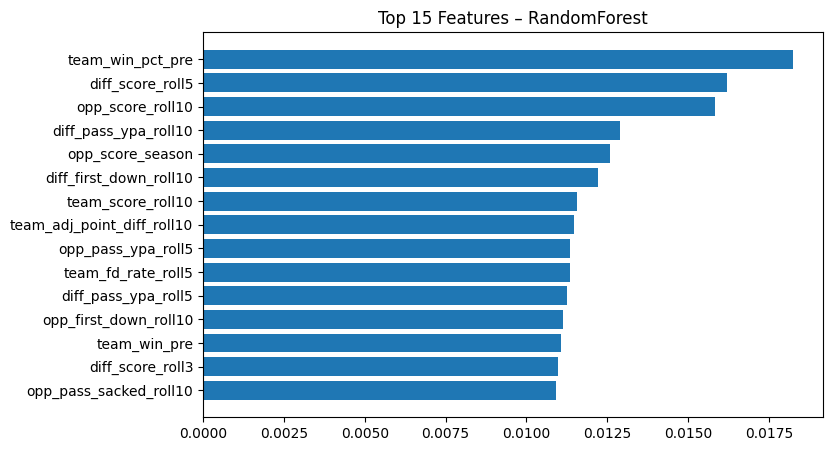


[XGBoost]
LogLoss: 0.7508 | AUC: 0.6369 | Brier: 0.2593 | Accuracy: 0.5947 | F1: 0.6024

Top 15 features for XGBoost:
diff_score_roll5               0.0156
team_win_pct_pre               0.0148
opp_score_roll10               0.0109
team_win_prev1                 0.0102
inj_K_prior1                   0.0101
int_is_home__team_win_pct_pre  0.0100
diff_turnovers_roll10          0.0100
is_home                        0.0099
opp_pass_sacked_roll10         0.0097
prac_sev_C_prior1              0.0095
prac_sev_QB_prior1             0.0093
surface_fieldturf              0.0091
prac_sev_CB_prior1             0.0091
team_xpa_prior1                0.0090
team_losses_pre                0.0087

Bottom 5 features for XGBoost:
team_fga_roll5                 0.0053
surface_sportturf              0.0051
opp_pass_int_prior1            0.0051
opp_pass_sacked_prior1         0.0051
temp_bin_gt_80                 0.0042


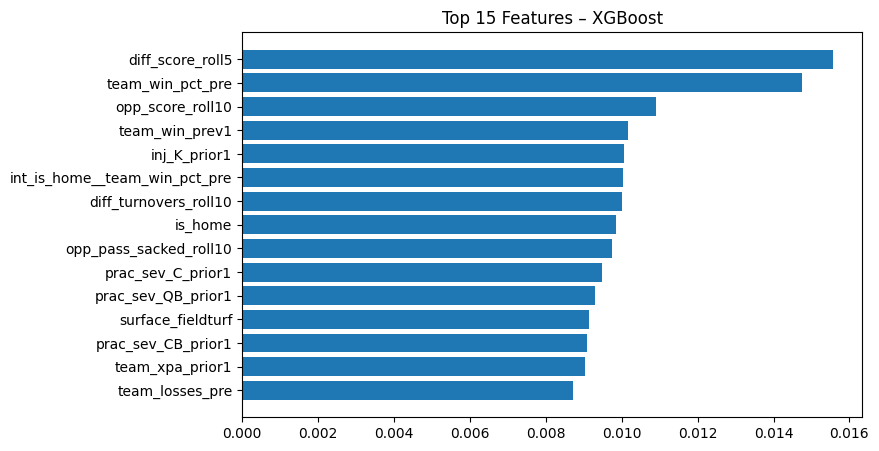


[RF (calibrated)]  LogLoss=0.7669  AUC=0.6697  Brier=0.2293  Acc=0.6228  F1=0.6452


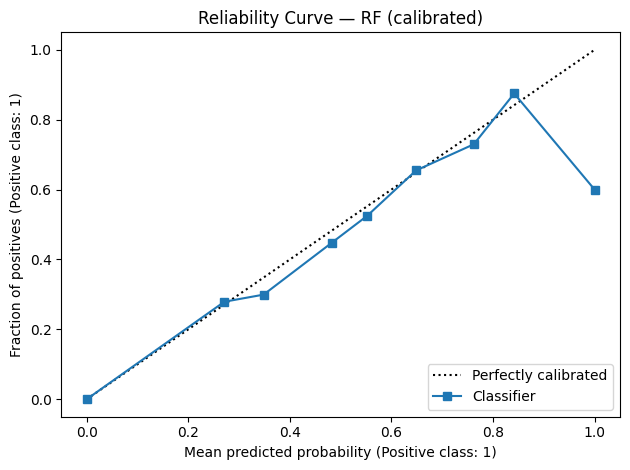


[XGB (calibrated)]  LogLoss=0.6690  AUC=0.6364  Brier=0.2383  Acc=0.5939  F1=0.5644


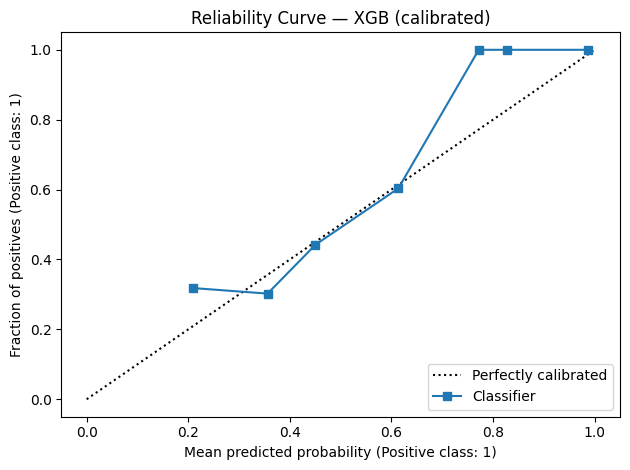

Tuned blend alphas — RF: 0.90, XGB: 0.90

Bets: 317 | P&L: -21.41 | ROI: -0.068 | Hit: 0.379 | Avg edge: 0.158 | Avg stake: 1.00

Bets: 304 | P&L: -16.79 | ROI: -0.055 | Hit: 0.342 | Avg edge: 0.161 | Avg stake: 1.00

Top RF edges:
      season  week team opponent  team_moneyline  team_prob_novig   p_model  \
608     2024    18   LA      SEA           285.0         0.249187  0.717226   
464     2024    20  HOU       KC           410.0         0.188133  0.627264   
8       2023     9  ARI      CLE           525.0         0.153499  0.577850   
949     2024     7  PIT      NYJ           140.0         0.400361  0.801575   
736     2024     5  MIN      NYJ          -142.0         0.563492  0.956349   
263     2023    18  CLE      CIN           285.0         0.249187  0.633369   
773     2024     7   NE      JAX           240.0         0.282029  0.636654   
337     2024     4  DEN      NYJ           330.0         0.223167  0.564624   
767     2024     1   NE      CIN           295.0         

In [214]:
# --- 8) Pipelines (use kept_cols)
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), kept_cols)
], remainder="drop")

rf = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42
    ))
])

xgb = Pipeline([
    ("pre", pre),
    ("xgb", XGBClassifier(
        n_estimators=800, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, n_jobs=-1, random_state=42, objective="binary:logistic", eval_metric="logloss"
    ))
])

def evaluate_model(pipe, name, show_features=True, top_n=15):
    # Fit
    pipe.fit(X_train, y_train)
    p_test = pipe.predict_proba(X_test)[:, 1]  # probability team wins
    y_pred = (p_test >= 0.5).astype(int)

    # Core metrics
    ll   = log_loss(y_test, p_test)
    auc  = roc_auc_score(y_test, p_test)
    bs   = brier_score_loss(y_test, p_test)
    acc  = accuracy_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)

    print(f"\n[{name}]")
    print(f"LogLoss: {ll:.4f} | AUC: {auc:.4f} | Brier: {bs:.4f} | "
          f"Accuracy: {acc:.4f} | F1: {f1:.4f}")

    # Feature importance (if model supports it)
    if show_features:
        try:
            # Get model inside pipeline
            model = pipe.named_steps.get("rf") or pipe.named_steps.get("xgb")
            importances = model.feature_importances_
            feats = pipe.named_steps["pre"].transformers_[0][2]  # num_cols list
            feat_imp = sorted(zip(feats, importances), key=lambda x: x[1], reverse=True)
            
            print(f"\nTop {top_n} features for {name}:")
            for f, val in feat_imp[:top_n]:
                print(f"{f:30s} {val:.4f}")
            
            print(f"\nBottom 5 features for {name}:")
            for f, val in feat_imp[-5:]:
                print(f"{f:30s} {val:.4f}")

            # Optional: barplot
            plt.figure(figsize=(8,5))
            plt.barh([f for f, _ in feat_imp[:top_n]][::-1],
                     [v for _, v in feat_imp[:top_n]][::-1])
            plt.title(f"Top {top_n} Features – {name}")
            plt.show()
        except Exception as e:
            print(f"(No feature importance available: {e})")

    return p_test

# --- Extra prints about split and features
print("\n--- Data Split Summary ---")
print(f"Train seasons: {sorted(train['season'].unique())}")
print(f"Test season : {sorted(test['season'].unique())}")
print(f"Train size  : {len(train)} rows")
print(f"Test size   : {len(test)} rows")
print(f"Features used: {len(kept_cols)}")

# --- Run evaluations
p_rf  = evaluate_model(rf,  "RandomForest")
p_xgb = evaluate_model(xgb, "XGBoost")

from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss, accuracy_score, f1_score
import matplotlib.pyplot as plt

# 1) Split your TRAIN into (fit) and (calibration) without shuffling (time-respecting)
X_fit, X_cal, y_fit, y_cal = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)

# 2) Fit base models on earlier slice
rf.fit(X_fit, y_fit)
xgb.fit(X_fit, y_fit)

# 3) Calibrate on the later slice (prefit)
cal_rf  = CalibratedClassifierCV(rf,  method="isotonic", cv="prefit")
cal_xgb = CalibratedClassifierCV(xgb, method="isotonic", cv="prefit")
cal_rf.fit(X_cal, y_cal)
cal_xgb.fit(X_cal, y_cal)

# 4) Evaluate on your true TEST split
def eval_calibrated(model, name):
    p = model.predict_proba(X_test)[:,1]
    yhat = (p >= 0.5).astype(int)
    print(f"\n[{name}]  LogLoss={log_loss(y_test,p):.4f}  AUC={roc_auc_score(y_test,p):.4f}  "
          f"Brier={brier_score_loss(y_test,p):.4f}  Acc={accuracy_score(y_test,yhat):.4f}  F1={f1_score(y_test,yhat):.4f}")
    CalibrationDisplay.from_predictions(y_test, p, n_bins=10)
    plt.title(f"Reliability Curve — {name}")
    plt.tight_layout()
    plt.show()
    return p

p_rf_cal  = eval_calibrated(cal_rf,  "RF (calibrated)")
p_xgb_cal = eval_calibrated(cal_xgb, "XGB (calibrated)")

# --- 4b) Minimal addition: tune alpha on CAL and blend with market (no-vig) on TEST
# Rebuild from CAL to avoid any leakage/mismatch
X_cal        = cal[kept_cols].copy()
y_cal        = cal["team_win"].to_numpy()
p_cal_novig  = cal["team_prob_novig"].to_numpy()

# Calibrated probs on CAL (used to tune alpha)
p_cal_rf     = cal_rf.predict_proba(X_cal)[:, 1]
p_cal_xgb    = cal_xgb.predict_proba(X_cal)[:, 1]

# --- tune alpha on CAL only ---
def tune_alpha(p_model, p_nv, y, grid=np.linspace(0.3, 0.9, 13)):
    from sklearn.metrics import brier_score_loss
    best_a, best_s = None, 1e9
    for a in grid:
        p = a*p_model + (1-a)*p_nv
        s = brier_score_loss(y, p)
        if s < best_s:
            best_a, best_s = a, s
    return best_a

alpha_rf  = tune_alpha(p_cal_rf,  p_cal_novig, y_cal)
alpha_xgb = tune_alpha(p_cal_xgb, p_cal_novig, y_cal)
print(f"Tuned blend alphas — RF: {alpha_rf:.2f}, XGB: {alpha_xgb:.2f}")

# --- now build TEST arrays (separately) ---
X_test        = test[kept_cols].copy()
y_test        = test["team_win"].to_numpy()
p_test_novig  = test["team_prob_novig"].to_numpy()

# Calibrated probs on TEST
p_test_rf_cal  = cal_rf.predict_proba(X_test)[:, 1]
p_test_xgb_cal = cal_xgb.predict_proba(X_test)[:, 1]

# Blended probs on TEST
p_test_rf_blend  = alpha_rf  * p_test_rf_cal  + (1 - alpha_rf)  * p_test_novig
p_test_xgb_blend = alpha_xgb * p_test_xgb_cal + (1 - alpha_xgb) * p_test_novig

# --- 5) Betting helpers (unchanged interfaces + minimal add-ons)

def american_to_decimal(ml):
    ml = float(ml)
    return 1 + (ml/100.0 if ml > 0 else 100.0/abs(ml))

def prob_to_amer(p):
    p = float(p)
    if p <= 0 or p >= 1:
        return np.nan
    mult = (1 - p) / p
    return int(round(100*mult)) if mult >= 1 else int(round(-100/mult))

def fair_decimal_from_prob(p):
    return 1.0 / max(p, 1e-12)

def ev_from_prob_amer(p_win, amer, stake=1.0):
    d = american_to_decimal(amer)
    return p_win*(stake*(d-1.0)) - (1-p_win)*stake  # units

def fmt_money(x): return f"${x:,.2f}"
def fmt_pct(x):   return f"{100*x:.1f}%"
def fmt_amer(a):  a = int(round(a)); return f"{'+' if a>0 else ''}{a}"

UNIT = 100.0  # $ per unit for display

def betting_line_equivalent_from_hit(hit):
    return fmt_amer(prob_to_amer(hit)) if pd.notna(hit) else "—"

def simulate_bets(
    test_df,
    p_model,
    edge_thresh=0.06,
    stake=1.0,
    p_novig_col="team_prob_novig",
    moneyline_col="team_moneyline",
    win_col="team_win",
    prob_window=(0, 1),   # new: only bet in this prob range
    odds_cap=(-600, 600),       # new: cap extreme odds
    kelly_frac=0.0              # new: 0.0 = flat; set 0.25 for 1/4 Kelly
):
    out = test_df.copy().reset_index(drop=True)
    out["p_model"] = p_model
    out["p_novig"] = out[p_novig_col]
    out["edge"]    = out["p_model"] - out["p_novig"]

    # probability window & odds cap filters
    lo, hi = prob_window
    o_lo, o_hi = odds_cap
    mask_prob = (out["p_model"] >= lo) & (out["p_model"] <= hi)
    mask_odds = (out[moneyline_col] >= o_lo) & (out[moneyline_col] <= o_hi)

    # decision to bet: edge + filters
    out["bet"] = ((out["edge"] >= edge_thresh) & mask_prob & mask_odds).astype(int)

    # optional fractional Kelly on American odds
    def dec_payout(ml):
        return (ml/100.0) if ml > 0 else (100.0/abs(ml))

    if kelly_frac > 0:
        b = out[moneyline_col].apply(dec_payout).values
        p = out["p_model"].values
        q = 1 - p
        f = np.clip((b*p - q) / b, 0, 1)  # Kelly fraction
        out["stake"] = np.where(out["bet"]==1, kelly_frac * f * stake, 0.0)
    else:
        out["stake"] = np.where(out["bet"]==1, stake, 0.0)

    # profit per row
    def profit(row):
        if row["stake"] <= 0: 
            return 0.0
        dec = american_to_decimal(row[moneyline_col])
        return (row["stake"] * (dec - 1.0)) if row[win_col] == 1 else (-row["stake"])

    out["profit"] = out.apply(profit, axis=1)
    out["cum_profit"] = out["profit"].cumsum()

    # summary
    n_bets = int(out["bet"].sum())
    pnl    = float(out["profit"].sum())
    avg_stake = out.loc[out["bet"]==1, "stake"].mean() if n_bets>0 else 0.0
    roi    = pnl / (out["stake"].sum() if out["stake"].sum() > 0 else 1.0)
    hit    = out.loc[out["bet"]==1, win_col].mean() if n_bets > 0 else np.nan
    avg_edge = out.loc[out["bet"]==1, "edge"].mean() if n_bets > 0 else np.nan

    print(f"\nBets: {n_bets} | P&L: {pnl:.2f} | ROI: {roi:.3f} | Hit: {hit:.3f} | "
          f"Avg edge: {avg_edge:.3f} | Avg stake: {avg_stake:.2f}")
    return out[["season","week","team","opponent",moneyline_col,p_novig_col,"p_model","edge","bet",win_col,"stake","profit","cum_profit"]]

# Run sims with blended probabilities (minimal change to your calls)
# Tunable knobs: edge_thresh, prob_window, odds_cap, kelly_frac
sim_rf  = simulate_bets(
    test, p_test_rf_blend,
    edge_thresh=0.08,               # slightly stricter
    stake=1.0,
    prob_window=(0.20, 0.80),       # avoid tails where calibration was weak
    odds_cap=(-300, 400),           # reduce longshot variance
    kelly_frac=0.00                  # set 0.25 for quarter-Kelly if desired
)

sim_xgb = simulate_bets(
    test, p_test_xgb_blend,
    edge_thresh=0.08,
    stake=1.0,
    prob_window=(0.20, 0.80),
    odds_cap=(-300, 400),
    kelly_frac=0.00
)

# --- 7) (Optional) quick peek at best edges & bankroll tail (unchanged)
print("\nTop RF edges:")
print(sim_rf.sort_values("edge", ascending=False).head(10))

print("\nFinal bankroll (RF/XGB):", sim_rf["cum_profit"].iloc[-1], "/", sim_xgb["cum_profit"].iloc[-1])

# --- Ticket-style summary with $ amounts (unchanged aside from column names already present)
UNIT = 100  # stake per bet in dollars

def ticket_summary(sim_df, model_name="Model", top_n=10, unit=UNIT):
    df = sim_df.loc[sim_df["bet"] == 1].copy()
    if df.empty:
        print(f"\n[{model_name}] No bets placed.")
        return

    def payout_from_american(ml):
        ml = float(ml)
        return (ml/100.0 * unit) if ml > 0 else (100.0/abs(ml) * unit)

    df["payout"] = df["team_moneyline"].astype(float).apply(payout_from_american)
    df["ev_$"] = df.apply(
        lambda r: r["p_model"]*r["payout"] - (1-r["p_model"])*unit, axis=1
    )

    print(f"\n[{model_name}] Ticket-style Top {top_n} edges (per ${unit} flat bet):")
    for _, r in df.sort_values("edge", ascending=False).head(top_n).iterrows():
        amer = int(r["team_moneyline"])
        print(
            f"{int(r['season'])} W{int(r['week'])} {r['team']} vs {r['opponent']} | "
            f"Line {amer:+} | Imp {r['team_prob_novig']:.3f} | "
            f"Model {r['p_model']:.3f} | Edge {r['edge']:.3f} | "
            f"EV/ ${unit}: {r['ev_$']:+.2f}"
        )

    pnl_units = df["profit"].sum()
    pnl_dollars = pnl_units * unit
    roi = pnl_units / len(df) if len(df) > 0 else 0
    print(f"\nFinal bankroll [{model_name}]: {pnl_units:+.2f} units ({pnl_dollars:+.2f} $)")
    print(f"ROI per bet: {roi:.3f}")

ticket_summary(sim_rf,  "RandomForest (blend)", top_n=10, unit=100)
ticket_summary(sim_xgb, "XGBoost (blend)",     top_n=10, unit=100)